In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import hiddenlayer as hl
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from math import sqrt
import os
os.getcwd()

'/Users/clause/Desktop/ZD/St'

In [2]:
train = pd.read_csv('/Users/clause/Desktop/ZD/train.csv', index_col = 0)
test = pd.read_csv('/Users/clause/Desktop/ZD/test.csv', index_col = 0)

In [3]:
train.head()

,0,1,2,3,4,5,6,7,0.1
0,0.652778,0.0,0.0,1.237158,-0.485387,-0.186567,-0.639733,0.0,0
1,0.438889,0.0,0.0,-0.017201,-0.324686,0.515736,-0.158885,1.0,0
2,0.466667,0.0,0.0,0.484542,0.234839,-0.537718,-0.701237,1.0,0
3,0.166667,0.0,0.0,0.484542,0.047138,-0.537718,0.584752,1.0,0
4,0.177778,0.0,0.0,-1.271561,-0.488966,-0.186567,-0.530704,1.0,0


In [4]:
train.rename(columns={'0.1': 'target'}, inplace=True)
test.rename(columns={'0.1': 'target'}, inplace=True)

In [5]:
X_train, y_train, X_test, y_test = train.iloc[:,:-1], train.iloc[:,-1], test.iloc[:,:-1], test.iloc[:,-1]

In [21]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.005

In [7]:
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)
    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
    
    def __len__(self):
        return len(self.X_data)


In [8]:
train_data = trainData(torch.FloatTensor(X_train.values),
                       torch.FloatTensor(y_train.values))    

test_data = testData(torch.FloatTensor(X_test.values))

In [9]:
train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = 1)

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.layer_1 = nn.Linear(8, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [11]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(8, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p = 0.1),
            nn.Linear(64, 1),
            nn.ReLU()
        )
        
    def forward(self, inputs):
        x = self.mlp(inputs)
        
        return x

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


MLP(
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.1, inplace=False)
    (10): Linear(in_features=64, out_features=1, bias=True)
    (11): ReLU()
  )
)


/Users/clause/Anaconda/anaconda3/envs/ML/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:712: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +
/Users/clause/Anaconda/anaconda3/envs/ML/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:712: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  warnings.warn("ONNX export mode is set to " + training_mode +


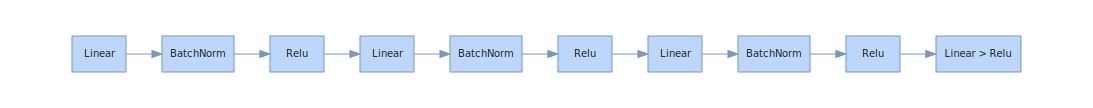

In [13]:
model = MLP()
model.to(device)

print(model)

vis_graph = hl.build_graph(model, torch.zeros([200, 8]))
vis_graph.theme = hl.graph.THEMES["blue"].copy() 
vis_graph

In [14]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [15]:
def MLP_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [16]:
def MLP_mcc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    cm = confusion_matrix(y_test.detach().numpy(), y_pred_tag.detach().numpy())
    mcc = (cm[0,0]*cm[1,1]-cm[0,1]*cm[1,0])/sqrt((cm[0,0]+cm[0,1])*(cm[0,0]+cm[1,0])*(cm[1,1]+cm[0,1])*(cm[1,1]+cm[1,0]))
    
    return mcc

In [22]:
history = hl.History()
canvas = hl.Canvas()
model.train()
for e in range(1, EPOCHS + 1):
    epoch_loss = 0
    epoch_acc = 0
    epoch_mcc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = MLP_acc(y_pred, y_batch.unsqueeze(1))
        mcc = MLP_mcc(y_pred, y_batch.unsqueeze(1))
            
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_mcc += mcc.item()
    
    print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc:{epoch_acc/len(train_loader): .3f} Mcc:{epoch_mcc/len(train_loader): .3f}')
            
        

Epoch 001: | Loss:0.52978 | Acc: 84.140 Mcc: 0.685
Epoch 002: | Loss:0.52894 | Acc: 83.885 Mcc: 0.679
Epoch 003: | Loss:0.52850 | Acc: 84.025 Mcc: 0.681
Epoch 004: | Loss:0.52845 | Acc: 84.236 Mcc: 0.686
Epoch 005: | Loss:0.52968 | Acc: 84.096 Mcc: 0.683
Epoch 006: | Loss:0.52614 | Acc: 84.357 Mcc: 0.689
Epoch 007: | Loss:0.52795 | Acc: 84.217 Mcc: 0.685
Epoch 008: | Loss:0.52751 | Acc: 84.268 Mcc: 0.687
Epoch 009: | Loss:0.52665 | Acc: 84.395 Mcc: 0.690
Epoch 010: | Loss:0.52563 | Acc: 84.522 Mcc: 0.693
Epoch 011: | Loss:0.52483 | Acc: 84.204 Mcc: 0.685
Epoch 012: | Loss:0.52578 | Acc: 84.465 Mcc: 0.692
Epoch 013: | Loss:0.52371 | Acc: 84.561 Mcc: 0.693
Epoch 014: | Loss:0.52754 | Acc: 84.172 Mcc: 0.686
Epoch 015: | Loss:0.52236 | Acc: 84.688 Mcc: 0.695
Epoch 016: | Loss:0.52254 | Acc: 84.484 Mcc: 0.690
Epoch 017: | Loss:0.52478 | Acc: 84.006 Mcc: 0.682
Epoch 018: | Loss:0.52495 | Acc: 84.204 Mcc: 0.686
Epoch 019: | Loss:0.52056 | Acc: 84.713 Mcc: 0.695
Epoch 020: | Loss:0.52273 | Acc

In [ ]:
'''
if e % 1 == 0:
            
            history.log(e, 
                        train_loss = epoch_loss/len(train_loader), 
                        test_acc = epoch_acc/len(train_loader), 
                        test_mcc = epoch_mcc/len(train_loader)) 
                        #hidden_weight = model.mlp[0].weight)
            
            with canvas:
                canvas.draw_plot([history["train_loss"], history["test_acc"], history["hidden_weight"]], labels = ['LOSS', 'Accuracy', 'MCC'])
                #canvas.draw_image(history["hidden_weight"])
        
        #print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc:{epoch_acc/len(train_loader): .3f}')
        #print(f'Epoch {e+0:03}: | Loss:{epoch_loss/len(train_loader):.5f} | Acc:{epoch_acc/len(train_loader): .3f} Mcc:{epoch_mcc/len(train_loader): .3f}')
            
'''

In [23]:
def pred(x, test_loader):
    y_pred_list = []
    model.eval()
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred= model(X_batch)
            y_test_pred= torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
        
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    cm = confusion_matrix(x, y_pred_list)
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    mcc = (cm[0,0]*cm[1,1]-cm[0,1]*cm[1,0])/sqrt((cm[0,0]+cm[0,1])*(cm[0,0]+cm[1,0])*(cm[1,1]+cm[0,1])*(cm[1,1]+cm[1,0]))
    
    print('Confusion Matrix:')
    print(cm)
    print(f' Accurency:{acc}, MCC:{mcc}')

In [24]:
pred(y_test, test_loader)

Confusion Matrix:
[[3326  657]
 [ 112  427]]
 Accurency:0.8299425033171163, MCC:0.476077111455907
